In [2]:
import scanpy as sc
import scvi
import pandas as pd

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
Global seed set to 0
/opt/apps/python/3.8.0/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [4]:
adata_f1 = sc.read_h5ad("/share/crsp/lab/seyedam/share/igvf_pipeline/igvf_022/Kidney/kidney_processed.h5ad")



In [7]:
adata_f1.var_names  = adata_f1.var['gene_name']


In [8]:
ref_data = sc.read_h5ad("/share/crsp/lab/seyedam/share/igvf_pipeline/IGVF_analysis/annotated_tissues/Kidney_annotated.h5ad")


In [20]:
marker_genes_dict = {

    "Proximal tubule": ["Lrp2","Cubn","Slc13a1"],
    "Thick ascending limb": ["Umod","Esrrb","Casr"],
    "Endothelial": ["Flt1","Pecam1","Kdr"],
    "Fibroblast": ["C7","Fbln5","Frem1","Pdgfra"],
    "Principal cell": ["Aqp2", "Aqp3"],
    "Collecting duct": ["Fxyd4"],
    "Distal convoluted tubule": ["Slc12a3", "Fgf13", "Lhx1", "Trpm6"],
    "Podocyte": ["Wt1","Nphs1", "Nphs2"],
    "Connecting tubule": ["Hsd11b2", "Calb1","Kitl"],
    "Intercalated cell": ["Atp6v0d2"],
    "Intercalated cell type B": ["Slc4a9", "Slc26a4"],
    "Immune": ["Ptprc","Cd74","Adgre1"],
    "Intercalated cell type A": ["Slc4a1", "Kit", "Aqp6","Clnk"],

    "Smooth muscle": ["Myh11", "Acta2"],

    "Thin limb": ["Aqp1","Bst1"],
    "Ascending thin limb LOH": ["Epha7"],
    "Descending thin limb LOH": ["Cdh13","Fst"],
    "Ncam1": ["Ncam1"],
    "Myofibroblast": ["Col16a1","Gli2","Smoc2"],
    "Megf11": ["Megf11"],
    "Adipocyte": ["Adipoq", "Pnpla2"], 
}


In [ ]:
# 22 40 28 doublety

categories: 0, 1, 2, etc.
var_group_labels: Proximal tubule, Thick ascending limb, Endothelial, etc.


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


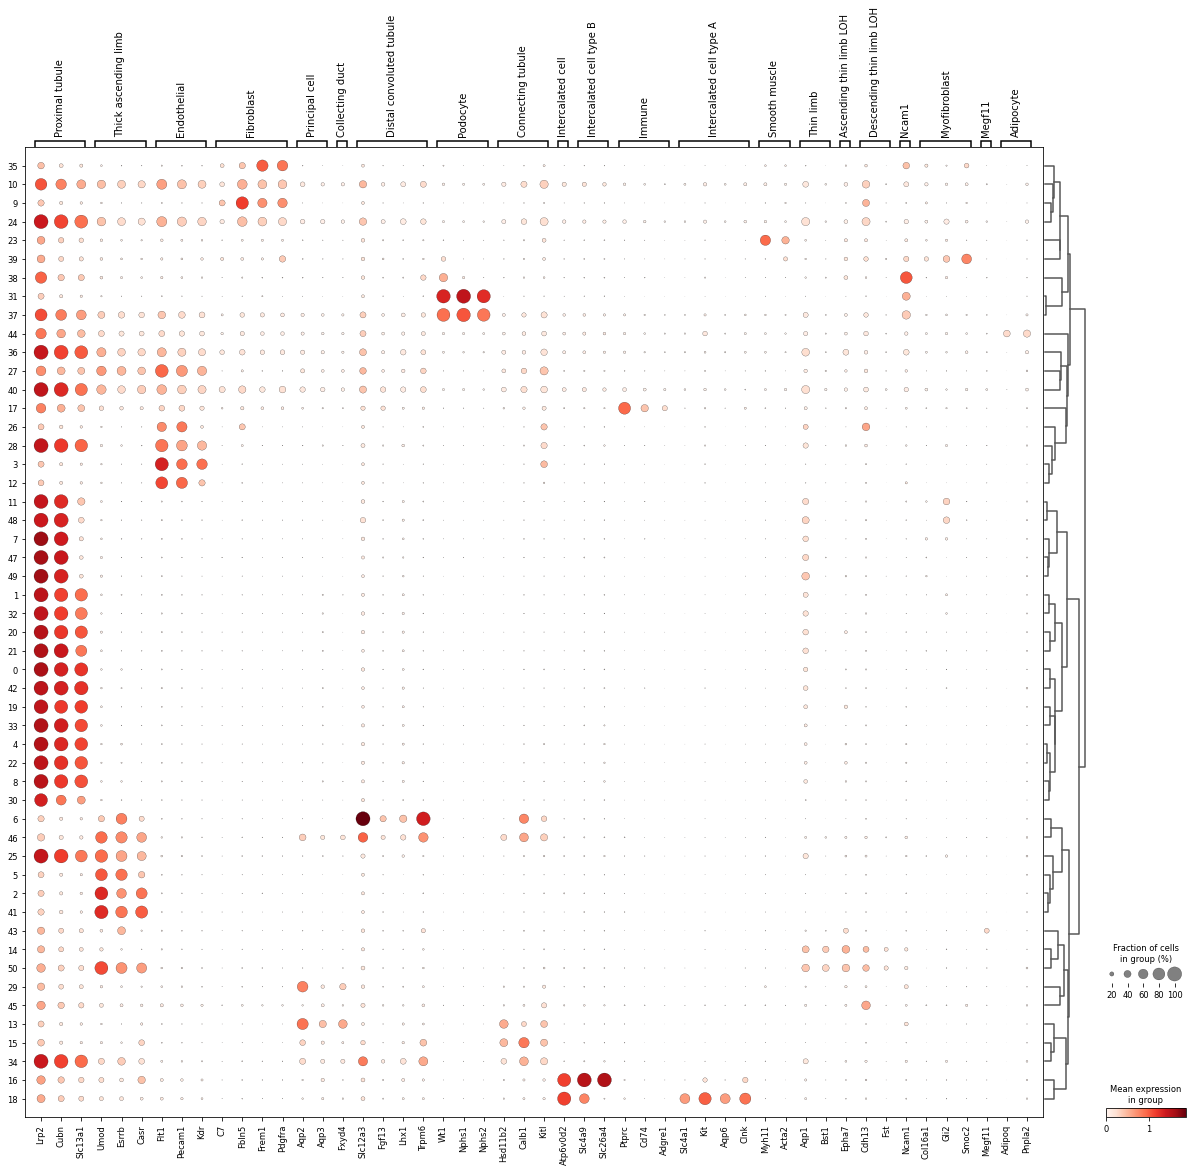

In [12]:
sc.pl.dotplot(ref_data, marker_genes_dict, 'leiden',
              dendrogram=True, log=True)

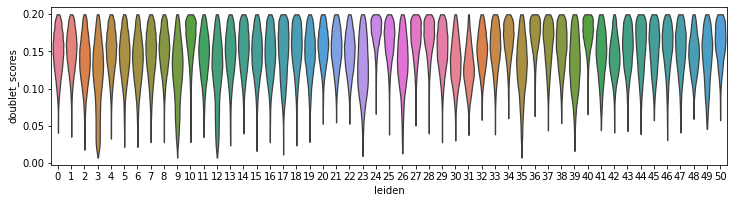

In [13]:
plt.rcParams['figure.figsize'] = (10, 3)

sc.pl.violin(ref_data, ['doublet_scores'],
             groupby = "leiden", 
             jitter=0.4, multi_panel=True, size=0)


In [ ]:
#adata = anndata.concat([adata_f1, ref_data], merge = "same")
adata = adata_f1.concatenate(ref_data)


In [ ]:
#adata.layers["raw_counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)


In [ ]:
# hmmmm using seurat_v3...
sc.pp.highly_variable_genes(adata, flavor = 'seurat_v3', n_top_genes=2000,
                            layer = "raw_counts", subset = True)



In [ ]:
scvi.model.SCVI.setup_anndata(adata, layer = 'raw_counts')
vae = scvi.model.SCVI(adata)
vae.train()


In [ ]:
adata.obs['subtype'] = adata.obs['subtype'].cat.add_categories('Unknown')
adata.obs = adata.obs.fillna(value = {'subtype': 'Unknown'})



In [ ]:
lvae = scvi.model.SCANVI.from_scvi_model(vae, adata = adata, unlabeled_category = 'Unknown',
                                        labels_key = 'subtype')

lvae.train(max_epochs=20, n_samples_per_label=100)

adata.obs['predictions'] = lvae.predict(adata)

In [ ]:
adata.obs['cell_barcodes'] = adata.obs.index.map(lambda x: x[:-2])

cell_mapper = dict(zip(adata.obs.cell_barcodes, adata.obs.predictions))

In [ ]:
adata = sc.read_h5ad("/share/crsp/lab/seyedam/share/igvf_pipeline/igvf_022/Kidney/kidney_processed.h5ad")


In [ ]:
adata.obs['predictions'] = adata.obs.index.map(cell_mapper)


In [ ]:
adata.write_h5ad("/share/crsp/lab/seyedam/share/igvf_pipeline/igvf_022/Kidney/kidney_processed_predictions.h5ad")



In [15]:
adata_f1 = sc.read_h5ad("/share/crsp/lab/seyedam/share/igvf_pipeline/igvf_022/Kidney/kidney_processed_predictions.h5ad")



In [16]:
plt.rcParams['figure.figsize'] = (10, 8)


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


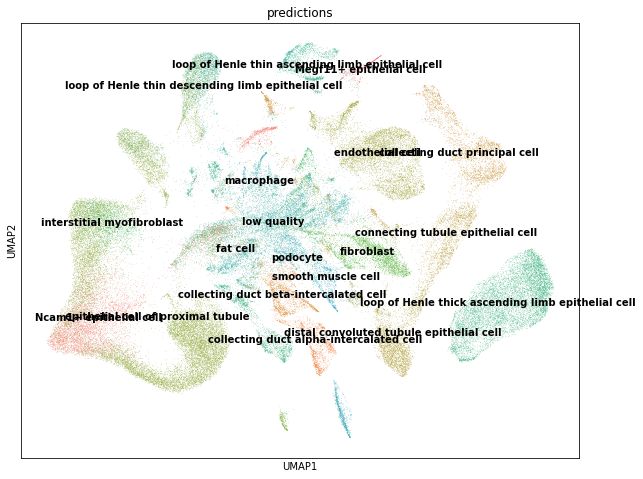

In [17]:
color_palette = sns.color_palette("husl", n_colors=30)

sc.pl.umap(adata_f1, color=['predictions'], size=1, legend_loc = 'on data',palette=color_palette)



In [18]:
obs = adata_f1.obs

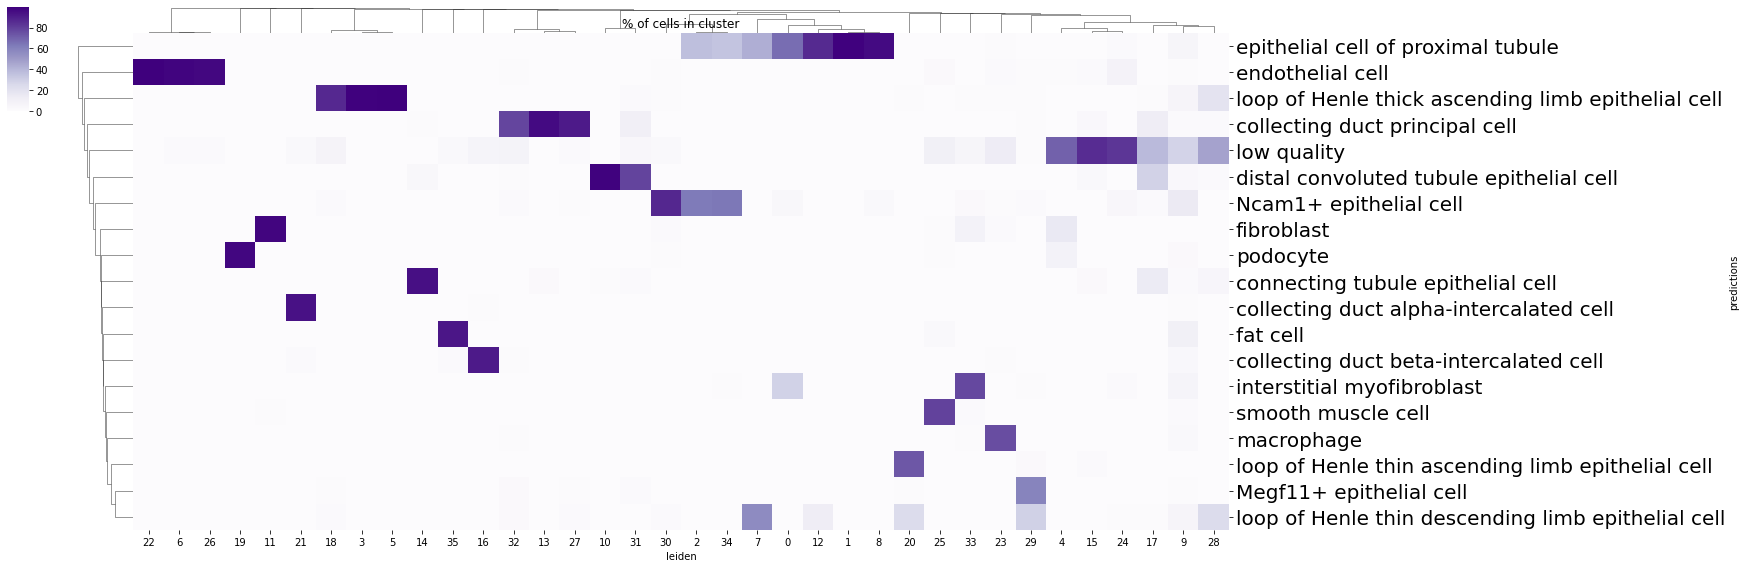

In [19]:
confusion_matrix_df = pd.crosstab(obs['leiden'], obs['predictions'])
confusion_matrix_df_percentage = confusion_matrix_df.div(confusion_matrix_df.sum(axis=1), axis=0) * 100
confusion_matrix_df_percentage_transposed = confusion_matrix_df_percentage.transpose()

g= sns.clustermap(confusion_matrix_df_percentage_transposed, 
               cmap='Purples',
               dendrogram_ratio=0.05,
               cbar_pos=(-0.04, 0.8, 0.015, 0.18),
               cbar=True,
               method='average', 
               metric='euclidean', 
               figsize=(20, 8), 
               col_cluster=True, 
               row_cluster=True)
g.ax_heatmap.set_title('% of cells in cluster')

for label in g.ax_heatmap.get_yticklabels():
    label.set_size(20)  # Set desired font size
    
plt.show()

In [22]:
adata_f1.var_names  = adata_f1.var['gene_name']


categories: 0, 1, 2, etc.
var_group_labels: Proximal tubule, Thick ascending limb, Endothelial, etc.


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


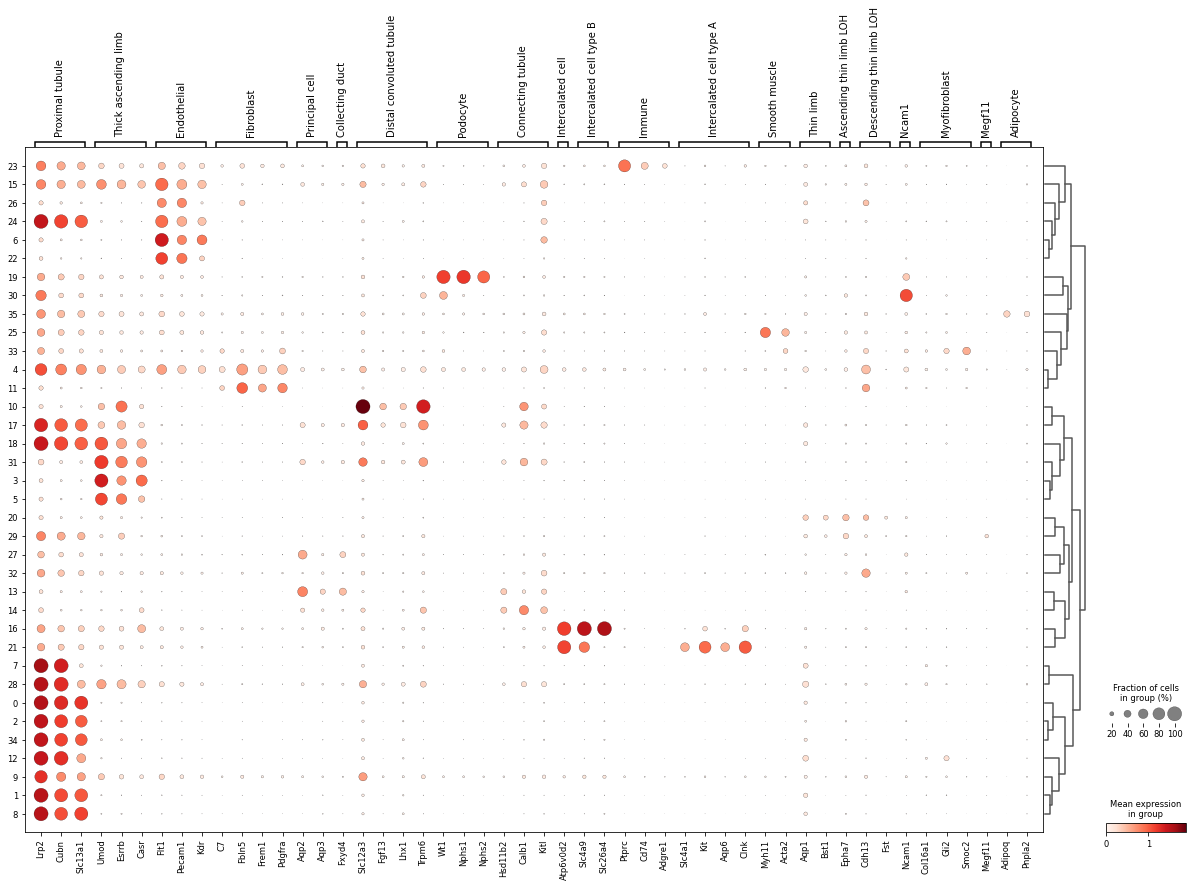

In [23]:
sc.pl.dotplot(adata_f1, 
              marker_genes_dict, 'leiden',
              dendrogram=True, log=True)